In [34]:
using Distributions, TimeIt, PyPlot, NPZ, JLD, ProgressMeter, CSV
include("zz_structures.jl")
include("mbsampler.jl")

get_clustering (generic function with 1 method)

In [2]:
data = CSV.read("/xtmp/PDMP_data/risk_factors_cervical_cancer.csv")
name = names(data);
predictors = vcat(Array(2:25), Array(27:28));

In [3]:
for i in predictors
    present = map(x->parse(Float64,x),data[name[i]][data[name[i]] .!= "?"])
    present_mean = mean(present)
    absent = data[name[i]] .== "?"
    data[name[i]][absent] = string(present_mean)
    data[name[i]] = map(x->parse(Float64,x),data[name[i]])     
    print(i, " ")
end 
y = Int64.(data[name[29]]);
data = Float64.(convert(Array, data));

2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 27 28 

In [4]:
x = data[:,(sum(abs.(data),1) .!= 0)[1,:]];
X = sparse(x')
d, Nobs = size(X);
my_ll = ll_logistic_sp(X,y);
my_prior = gaussian_prior_nh(zeros(d),1*ones(d))
my_model = model(my_ll, my_prior)
σ02 = 1
root = find_root(my_model, rand(d));
gc()

In [5]:
β_0 = copy(root)
mb_size = 2

2

In [6]:
# Sub-sampling with weights and no CV

gs = Array{mbsampler}(d)
gs[1] = umbsampler(Nobs, mb_size)
@showprogress for i in 2:d 
    nz_ind = X[i,:].nzind
    weights_het = spzeros(Nobs)
    weights_het[nz_ind] = abs.(X[i,nz_ind])./sum(abs.(X[i,nz_ind]))
    prob_het = (length(nz_ind)==length(X[i,:])) + 0.98*(length(nz_ind)!=length(X[i,:]))
    gs[i] = spwumbsampler(Nobs, mb_size, weights_het, prob_het)
end
gs_list_wt_noCV = mbsampler_list(d,gs);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


In [7]:
# Sub-sampling with weights and with CV 

norm_Xj = [norm(X[:,j]) for j in 1:Nobs]
mbs = Array{mbsampler}(d)
for i in 1:d 
    nz_ind = X[i,:].nzind
    weights_het = spzeros(Nobs)
    weights_het[nz_ind] = abs.(X[i,nz_ind]).*norm_Xj[nz_ind]
    prob_het = (length(nz_ind)==length(X[i,:])) + 0.98*(length(nz_ind)!=length(X[i,:]))
    mbs[i] = spwumbsampler(Nobs, mb_size, weights_het, prob_het)
end
gs_list_wt_CV = cvmbsampler_list(my_model, mbs, root, true);

In [8]:
# Stratified sub-sampling without CV and with weights 

weights = sparse(abs.(X))
for i in 1:d 
    weights[i,:] /= sum(weights[i,:])
end

ll_pd_root_list = [partial_derivative_vec(my_model.ll, root, i, 1:Nobs) for i in 1:d]

cmbsamplers = Array{mbsampler}(d)
N_cluster = mb_size

for dim in 1:d
    
    N_cluster_d = min(N_cluster, length(ll_pd_root_list[dim].nzval))
    csamplers = Array{mbsampler}(N_cluster_d)
    
    clusters = get_clustering(N_cluster_d, ll_pd_root_list[dim].nzval)
    for i in 1:N_cluster_d
        clusters[i] =  ll_pd_root_list[dim].nzind[clusters[i]]
    end
    #print(clusters)
    scp = ones(N_cluster_d)
    for (ci, c) in enumerate(clusters)
        csamplers[ci] = wumbsampler(size(c)[1], scp[ci], weights[dim,c])
    end
    cmbsamplers[dim] = spcmbsampler(csamplers, clusters, weights[dim,:])
end
gs_list_wt_noCV_ss = mbsampler_list(d,cmbsamplers);

In [9]:
# Stratified sub-sampling with CV and with weights

norm_Xj = [norm(X[:,j]) for j in 1:Nobs]
weights_cv = spzeros(d, Nobs)
for i in 1:d 
    nz_ind = X[i,:].nzind
    weights_cv[i,nz_ind] = abs.(X[i,nz_ind]).*norm_Xj[nz_ind] 
    weights_cv[i,nz_ind] /= sum(weights_cv[i,nz_ind])
end

ll_pd_root_list = [partial_derivative_vec(my_model.ll, root, i, 1:Nobs) for i in 1:d]

cmbsamplers = Array{mbsampler}(d)
N_cluster = mb_size

for dim in 1:d
    N_cluster_d = min(N_cluster, length(ll_pd_root_list[dim].nzval))
    
    csamplers = Array{mbsampler}(N_cluster_d)
    clusters = get_clustering(N_cluster_d, ll_pd_root_list[dim].nzval)
    for i in 1:N_cluster_d
        clusters[i] =  ll_pd_root_list[dim].nzind[clusters[i]]
    end

    scp = ones(N_cluster_d)
    for (ci, c) in enumerate(clusters)
        csamplers[ci] = wumbsampler(size(c)[1], scp[ci], weights_cv[dim,c])
    end
    cmbsamplers[dim] = spcmbsampler(csamplers, clusters, weights_cv[dim,:])
end
gs_list_wt_CV_ss = cvmbsampler_list(my_model, cmbsamplers, root, true);

#### Run algorithms:

In [10]:
A = eye(d)

opf = projopf(A, 100)
opt = maxa_opt(10^8)
adapt_speed = "none"
L = 2

2

In [11]:
mstate_wt_noCV = zz_state(d);
bb_ll_wt_noCV = build_bound(my_model.ll, gs_list_wt_noCV)
bb_pr_wt_noCV = build_bound(my_model.pr)
update_bound(bb_pr_wt_noCV, my_model.pr, mstate_wt_noCV)
update_bound(bb_ll_wt_noCV, my_model.ll, mstate_wt_noCV, gs_list_wt_noCV)

my_zz_sampler_wt_noCV = zz_sampler_decoupled(0, gs_list_wt_noCV, bb_pr_wt_noCV, bb_ll_wt_noCV, L, adapt_speed)
ZZ_sample_decoupled(my_model, outp_wt_noCV, my_zz_sampler_wt_noCV, mstate_wt_noCV);

10% attempts in 18.73 mins 
20% attempts in 37.91 mins 
30% attempts in 57.1 mins 
40% attempts in 77.29 mins 
50% attempts in 97.84 mins 
60% attempts in 118.84 mins 
70% attempts in 139.7 mins 
80% attempts in 161.13 mins 
90% attempts in 182.44 mins 
100% attempts in 204.4 mins 


In [12]:
mstate_wt_CV = zz_state(d);
bb_ll_wt_CV = build_bound(my_model.ll, gs_list_wt_CV)
bb_pr_wt_CV = build_bound(my_model.pr)
update_bound(bb_pr_wt_CV, my_model.pr, mstate_wt_CV)
update_bound(bb_ll_wt_CV, my_model.ll, mstate_wt_CV, gs_list_wt_CV)

my_zz_sampler_wt_CV = zz_sampler_decoupled(0, gs_list_wt_CV, bb_pr_wt_CV, bb_ll_wt_CV, L, adapt_speed)
ZZ_sample_decoupled(my_model, outp_wt_CV, my_zz_sampler_wt_CV, mstate_wt_CV);

10% attempts in 19.88 mins 
20% attempts in 39.43 mins 
30% attempts in 58.19 mins 
40% attempts in 76.99 mins 
50% attempts in 95.97 mins 
60% attempts in 115.14 mins 
70% attempts in 135.11 mins 
80% attempts in 154.39 mins 
90% attempts in 173.85 mins 
100% attempts in 193.07 mins 


In [13]:
mstate_wt_noCV_ss = zz_state(d);
bb_ll_wt_noCV_ss = build_bound(my_model.ll, gs_list_wt_noCV_ss)
bb_pr_wt_noCV_ss = build_bound(my_model.pr)
update_bound(bb_pr_wt_noCV_ss, my_model.pr, mstate_wt_noCV_ss)
update_bound(bb_ll_wt_noCV_ss, my_model.ll, mstate_wt_noCV_ss, gs_list_wt_noCV_ss)

my_zz_sampler_wt_noCV_ss = zz_sampler_decoupled(0, gs_list_wt_noCV_ss, bb_pr_wt_noCV_ss, 
    bb_ll_wt_noCV_ss, L, adapt_speed)
ZZ_sample_decoupled(my_model, outp_wt_noCV_ss, my_zz_sampler_wt_noCV_ss, mstate_wt_noCV_ss);

10% attempts in 22.47 mins 
20% attempts in 46.4 mins 
30% attempts in 69.67 mins 
40% attempts in 93.95 mins 
50% attempts in 118.53 mins 
60% attempts in 143.17 mins 
70% attempts in 168.65 mins 
80% attempts in 193.85 mins 
90% attempts in 219.04 mins 
100% attempts in 244.41 mins 


In [14]:
mstate_wt_CV_ss = zz_state(d);
bb_ll_wt_CV_ss = build_bound(my_model.ll, gs_list_wt_CV_ss)
bb_pr_wt_CV_ss = build_bound(my_model.pr)
update_bound(bb_pr_wt_CV_ss, my_model.pr, mstate_wt_CV_ss)
update_bound(bb_ll_wt_CV_ss, my_model.ll, mstate_wt_CV_ss, gs_list_wt_CV_ss)

my_zz_sampler_wt_CV_ss = zz_sampler_decoupled(0, gs_list_wt_CV_ss, bb_pr_wt_CV_ss, 
    bb_ll_wt_CV_ss, L, adapt_speed)
ZZ_sample_decoupled(my_model, outp_wt_noCV_ss, my_zz_sampler_wt_CV_ss, mstate_wt_CV_ss);

10% attempts in 22.73 mins 
20% attempts in 46.24 mins 
30% attempts in 69.1 mins 
40% attempts in 92.01 mins 
50% attempts in 115.08 mins 
60% attempts in 138.27 mins 
70% attempts in 161.07 mins 
80% attempts in 183.8 mins 
90% attempts in 206.55 mins 
100% attempts in 229.31 mins 


In [39]:
discard, n_samples = 0, 10^5
xi_samples_wt_noCV = extract_samples(outp_wt_noCV.opf.xi_skeleton[:,discard+1:end], 
                             outp_wt_noCV.opf.bt_skeleton[:,discard+1:end], 
                            (outp_wt_noCV.opf.bt_skeleton[end]-outp_wt_noCV.opf.bt_skeleton[discard+1])/n_samples,
                             "linear")
xi_samples_wt_CV = extract_samples(outp_wt_CV.opf.xi_skeleton[:,discard+1:end], 
                             outp_wt_CV.opf.bt_skeleton[:,discard+1:end], 
                            (outp_wt_CV.opf.bt_skeleton[end]-outp_wt_CV.opf.bt_skeleton[discard+1])/n_samples,
                             "linear")
xi_samples_wt_noCV_ss = extract_samples(outp_wt_noCV_ss.opf.xi_skeleton[:,discard+1:end], 
                             outp_wt_noCV_ss.opf.bt_skeleton[:,discard+1:end], 
                    (outp_wt_noCV_ss.opf.bt_skeleton[end]-outp_wt_noCV_ss.opf.bt_skeleton[discard+1])/n_samples,
                             "linear")
xi_samples_wt_CV_ss = extract_samples(outp_wt_CV_ss.opf.xi_skeleton[:,discard+1:end], 
                             outp_wt_CV_ss.opf.bt_skeleton[:,discard+1:end], 
                    (outp_wt_CV_ss.opf.bt_skeleton[end]-outp_wt_CV_ss.opf.bt_skeleton[discard+1])/n_samples,
                             "linear");

In [40]:
maxlag = 1000
acfs = zeros(4, d, maxlag)
for dim in 1:d 
    acfs[1,dim,:] = acf(xi_samples_wt_noCV[dim,:], maxlag)
    acfs[2,dim,:] = acf(xi_samples_wt_CV[dim,:], maxlag)
    acfs[3,dim,:] = acf(xi_samples_wt_noCV_ss[dim,:], maxlag)
    acfs[4,dim,:] = acf(xi_samples_wt_CV_ss[dim,:], maxlag)
end

In [41]:
acfs_wt_noCV, acfs_wt_CV, acfs_wt_noCV_ss, acfs_wt_CV_ss = [], [], [], []
xt = []
plot_freq = 50
for i in 1:Int(maxlag/plot_freq)
    push!(acfs_wt_noCV, acfs[1,:,i*10])
    push!(acfs_wt_CV, acfs[2,:,i*10])
    push!(acfs_wt_noCV_ss, acfs[3,:,i*10])
    push!(acfs_wt_CV_ss, acfs[4,:,i*10])
    if i%10 == 0 
        push!(xt, plot_freq*i)
    else 
        push!(xt, "")
    end
end

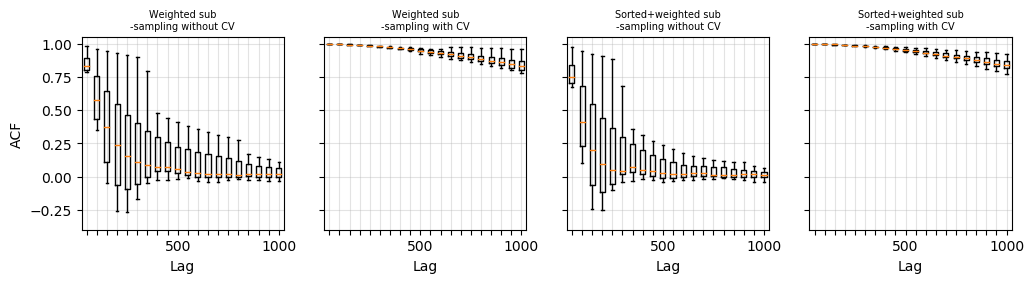

In [42]:
using PyPlot
fig = figure("pyplot_subplot_mixed", figsize=(12,2.5))

a, b = -0.4, 1.05
subplot(141)
boxplot(acfs_wt_noCV, showfliers=false)
grid(alpha=0.35)
xlabel("Lag", fontsize=10)
ylabel("ACF", fontsize=10)
xticks(1:Int(maxlag/plot_freq), xt)
ylim([a,b])
title("Weighted sub\n-sampling without CV", fontsize=7)

subplot(142)
boxplot(acfs_wt_CV, showfliers=false)
grid(alpha=0.35)
xlabel("Lag", fontsize=10)
xticks(1:Int(maxlag/plot_freq), xt)
ylim([a,b])
yticks(alpha=0)
title("Weighted sub\n-sampling with CV", fontsize=7)

subplot(143)
boxplot(acfs_wt_noCV_ss, showfliers=false)
grid(alpha=0.35)
xlabel("Lag", fontsize=10)
xticks(1:Int(maxlag/plot_freq), xt)
yticks(alpha=0)
ylim([a,b])
title("Sorted+weighted sub\n-sampling without CV", fontsize=7)

subplot(144)
boxplot(acfs_wt_CV_ss, showfliers=false)
grid(alpha=0.35)
xlabel("Lag", fontsize=10)
xticks(1:Int(maxlag/plot_freq), xt)
yticks(alpha=0)
ylim([a,b])
title("Sorted+weighted sub\n-sampling with CV", fontsize=7);

In [43]:
mean(sum(acfs,3),2)

4×1×1 Array{Float64,3}:
[:, :, 1] =
  89.5903
 508.833 
  61.2844
 517.827 

In [44]:
maximum(sum(acfs,3),2)

4×1×1 Array{Float64,3}:
[:, :, 1] =
 545.414
 947.492
 470.458
 937.893

In [36]:
B = 100
print(round(minimum(compute_ESS(outp_wt_noCV.opf, B))), "\n")
print(round(minimum(compute_ESS(outp_wt_CV.opf, B))), "\n")
print(round(minimum(compute_ESS(outp_wt_noCV_ss.opf, B))), "\n")
print(round(minimum(compute_ESS(outp_wt_CV_ss.opf, B))), "\n")

203.0
113.0
363.0
108.0


In [37]:
print(round(mean(compute_ESS(outp_wt_noCV.opf, B))), "\n")
print(round(mean(compute_ESS(outp_wt_CV.opf, B))), "\n")
print(round(mean(compute_ESS(outp_wt_noCV_ss.opf, B))), "\n")
print(round(mean(compute_ESS(outp_wt_CV_ss.opf, B))), "\n")

28759.0
23353.0
59399.0
16355.0
